# PyTorch Implementation of Paper 
# "Active Gradual Domain Adaptation: Dataset and Approach"



In this notebook, we will:
1. Introduce example torch dataset classes for EVIS dataset.
2. Show the "gradual domain drift" inside the EVIS dataset.
3. Implement our AGST approach in the paper and compare with other baselines on the task of gradual domain adaptation on EIVS dataset. Ablation study is included.

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats
from copy import deepcopy
from PIL import Image

from generate_data_split import generate_data_split
from utils.evaluation import evaluate, evaluate_, evaluate_per_class, binary_accuracy
from model.ResNet import Model

### Define the torch dataset class for EVIS.

In [2]:
# Assign integer label for each category in EVIS dataset.
label_map = {
             1:'television', 
             2:'electronic watch',
             3:'laptop', 
             4:'phone', 
             5:'tablet pc',
             6:'Taxi', 
             7:'Car', 
             8:'Truck',
             9:'Van',
             0:'Bus' 
             }

In [3]:
trans = transforms.ToTensor()

def transform_train_():
    """
    Transform for training dataset.
    The input images are augmented by random cropping and random horizontal flipping.
    """
    mean_value = [0.485, 0.456, 0.406]
    std_value = [0.229, 0.224, 0.225]
    resize = 64
    crop_size = 60
    data_transforms = transforms.Compose([
        transforms.Resize(resize),
        transforms.RandomResizedCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_value, std_value)
    ])
    return data_transforms

def transform_test_():
    """
    Transform for testing dataset.
    """
    mean_value = [0.485, 0.456, 0.406]
    std_value = [0.229, 0.224, 0.225]
    resize = 64
    crop_size = 60
    data_transforms = transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean_value, std_value)
    ])
    return data_transforms

transform_train = transform_train_()
transform_test = transform_test_()

In [4]:
"""
data split files should have already exist in the dataset directories.
if not, excuete the below function.
"""
# generate_data_split("data/EVIS_40") 

'\ndata split files should have already exist in the dataset directories.\nif not, excuete the below function.\n'

In [5]:
class EVIS_month(Dataset):
    def __init__(self, root_dir, year, month, transform=None):
        """
        Evolution Image Search (EVIS) per month Dataset Class.
        return dataset class contains the data samples within a specific month range.
        
        Input Args:
            root_dir (string): Folder_name of the dataset. e.g: "data/EVIS_40"
            year (int), month(int).
            transform (callable, optional): Optional image transform.
        
        Note:
            'data_split.csv' should have already been located under each month folder.
            If not, run generate_data_split().
        """
        super(EVIS_month, self).__init__()
        self.root_dir = os.path.join(root_dir, str(year), str(month))
        self.transform = transform
        
        self.year = year
        self.month = month
        
        df = pd.read_csv(os.path.join(self.root_dir, 'data_split.csv'))
        paths = df['path']
        labels = df['label']
        self._paths = list(paths)
        self._labels = list(labels)
        
    def __len__(self):
        return len(self._paths)

    def __getitem__(self, idx): 
        path = self._paths[idx]
        label = self._labels[idx]
        
        img_path = os.path.join(self.root_dir, path)
        image = Image.open(img_path)       
            
        if self.transform:
            image = self.transform(image)
        else:
            image = trans(image)
            
        return image, label

In [6]:
class EVIS_year(Dataset):

    def __init__(self, root_dir, year, transform=None):
        """
        Evolution Image Search (EVIS) per year Dataset Class.
        return dataset class contains the data samples within a specific year range.
        
        Args:
            root_dir (string): Folder_name of the dataset. e.g: "data/EVIS_40"
            year (int), month(int).
            transform (callable, optional): Optional image transform.
        
        Note:
            'data_split_by_year.csv' should have already been located under each year folder.
            If not, run generate_data_split().
        """
        super(EVIS_year, self).__init__()
        self.root_dir = os.path.join(root_dir, str(year))
        self.transform = transform
        
        self.year = year
        
        df = pd.read_csv(os.path.join(self.root_dir, 'data_split_by_year.csv'))
        paths = df['path']
        labels = df['label']
        self._paths = list(paths)
        self._labels = list(labels)
        
    def __len__(self):
        return len(self._paths)

    def __getitem__(self, idx):       
        path = self._paths[idx]
        label = self._labels[idx]
        
        img_path = os.path.join(self.root_dir, path)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        else:
            image = trans(image)
             
        return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 60, 60])
phone


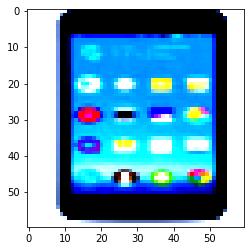

In [8]:
"""
test the implementation of the EVIS torch dataset.
"""

test_set = EVIS_year(root_dir = "data/EVIS_40", year = 2015, transform = transform_train)
# test_set = EVIS_month(root_dir = "data/EVIS_40", year = 2015, month = 1, transform = transform_train) 

test_loader = torch.utils.data.DataLoader(test_set)
x, y = next(iter(test_loader))
print(x.size())
test_idx = 0
x = x[test_idx].squeeze().permute(1, 2, 0).numpy()
plt.imshow(x)
print(label_map[y[test_idx].item()])

### Show the Gradual Domain Drift inside EVIS dataset

In [7]:
# Setting up GPU for training.
GPU_number = 0
device = torch.device(f"cuda:"+str(GPU_number) if torch.cuda.is_available() else "cpu")


# Display additional hardware info.
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_number))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_number)/1024**3,3), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(GPU_number)/1024**3,3), 'GB')

GeForce RTX 3080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [8]:
# Initialize the ResNet18 model.
model = Model(num_classes = 10).to(device)
saved_model_path = "saved_model/saved_model_0.pth"

The source model is trained on the 2009~2011 data.

Here you could either choose to train the model by yourself or just load the saved source model provided by us.

In [9]:
"""
Load the trained model.
"""
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [10]:
# """
# (Optional) Uncomment and run this cell if you want to train the source model by yourself.
# """

# #Training on a continuous source domain (2009~2011). 
# 2012 data is adopted for validation.

# model = Model(num_classes = 10).to(device)
# temp_model = Model(num_classes = 10).to(device)

# source_set1 = EVIS_year(root_dir = "data/EVIS_40", year = 2009, transform = transform_train)
# source_loader1 = torch.utils.data.DataLoader(source_set1,batch_size=64, shuffle=1, pin_memory=True, drop_last=True)
# source_set2 = EVIS_year(root_dir = "data/EVIS_40", year = 2010, transform = transform_train)
# source_loader2 = torch.utils.data.DataLoader(source_set2,batch_size=64, shuffle=1, pin_memory=True, drop_last=True)
# source_set3 = EVIS_year(root_dir = "data/EVIS_40", year = 2011, transform = transform_train)
# source_loader3 = torch.utils.data.DataLoader(source_set3,batch_size=64, shuffle=1, pin_memory=True, drop_last=True)

# valid_set = EVIS_year(root_dir = "data/EVIS_40", year = 2012, transform = transform_test)
# valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=64, shuffle=1, pin_memory=True, drop_last=True)

# max_acc = 0.01
# optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
# num_epochs = 300

# for epoch in range(0, num_epochs):

#     train_queue1 = iter(source_loader1)    
#     train_queue2 = iter(source_loader2)    
#     train_queue3 = iter(source_loader3)
#     optimizer.zero_grad()

#     for i, (x1, y1) in enumerate(train_queue1):
#         x1 = x1.to(device)
#         y1 = y1.to(device)
#         x2, y2 = next(train_queue2)
#         x3, y3 = next(train_queue3)
#         x2 = x2.to(device)
#         y2 = y2.to(device)
#         x3 = x3.to(device)
#         y3 = y3.to(device)
#         yhat1 = model(x1)
#         yhat2 = model(x2)
#         yhat3 = model(x3)
        
#         loss = 1 * F.cross_entropy(yhat1, y1) + 1.2 * F.cross_entropy(yhat2, y2) + 1.15 * F.cross_entropy(yhat3, y3)
#         #print(f'loss_tgt={loss.item():.2f} ')

#         #Optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
     
#     print(f'epoch {epoch}')
#     if not (epoch % 5):
#         print('Starting validation...')
#         #acc = evaluate_(model, vali_loader,device)
#         acc_list = evaluate_per_class(model, valid_loader,device)
#         print("acc_list = ",acc_list, sum(acc_list)/len(acc_list))
#         acc = sum(acc_list)/len(acc_list)
#         if acc > max_acc:
#             print("found a better acc")
#             max_acc = acc
#             temp_model.load_state_dict(model.state_dict())
# #     print("acc = ",acc)

# model.load_state_dict(temp_model.state_dict())

##### Visualize the Gradual Domain Drift of EVIS

The source model is now trained on data before 2011.

To see the gradual domain drift in the EVIS dataset, we use the source model to predict the intermedia domain data (e.g. from 2012 to 2018) and observe the decrease rate of accuracy.

/home/test0/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


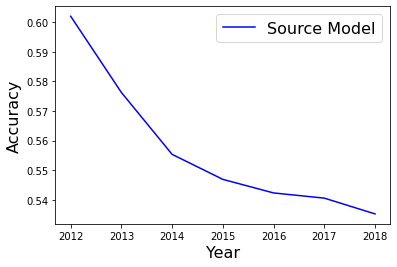

In [11]:
acc_list_ = []
for year in range(2012, 2019):
    valid_set = EVIS_year(root_dir = "data/EVIS_40", year = year, transform = transform_test)
    valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=64, shuffle=1, pin_memory=False, drop_last=True)
    acc = evaluate_(model, valid_loader, device)
    acc_list_.append(acc)
    
x_values = range(2012,2019)

plt.plot(x_values,acc_list_, label="Source Model", color='b')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
#plt.savefig("Fig_01.pdf")
plt.show()

###### Per Class Accuracy Decrease Rate.

Below we could see the result of the measurement of the degree of evolving over the last decade for the 10 selected objects. Accuracy decreasing rate is the approximated average amount of accuracy decrease per year for each category. 

(the approximation here is given by linear regression.)

Here we could observe that the object with the highest degree of evolution is the phone and the tablet computers followed by laptops, all of which have a decline rate larger than 0.02. The car also has a relatively high degree of evolution and is the vehicle whose decline rate is closest to the above three electronic products. The three least evolved objects are television, truck, and taxi. Taxi is holding a really small decreasing rate which is close to 0. The above statistical results are consistent with human's perception of the degree of evolution among these ten items.

In [12]:
list_of_acc_list = []
month = 6
for year in range(2011, 2021):
    valid_set = EVIS_year(root_dir = "data/EVIS_40", year = year, transform = transform_test)
    valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=64, shuffle=1, pin_memory=False, drop_last=True)
    acc_list = evaluate_per_class(model, valid_loader, device)
    #print("year = ",year, "month = ",month,"acc_list = ",acc_list, "acc", sum(acc_list)/len(acc_list))
    list_of_acc_list.append(acc_list)

In [13]:
# inverse the list of list for linear regression.
inversed_array = np.zeros((10, len(list_of_acc_list)))
for i in range(10):
    for j in range(len(list_of_acc_list)):
        inversed_array[i][j] = list_of_acc_list[j][i]
x_ = np.linspace(0, 1, num=10)

category_acc_decrese_rate = []
for i in range(0,10):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_,inversed_array[i])
    print(label_map[i], slope/10)
    category_acc_decrese_rate.append(slope/10)

Bus -0.010797376111507632
television -0.0176443707248938
electronic watch -0.006325123423569047
laptop -0.029068436244243656
phone -0.02937992813289343
tablet pc -0.023284795942875483
Taxi 0.0015801451038611695
Car -0.019854572938119645
Truck -0.013208888054525266
Van -0.008578366301157509


### Compare our methods and other baselines for gradual domain adaptation on EVIS dataset 

In [14]:
# year range.
start_year = 2012
end_year = 2020


# Hyperparameters.
alpha_threshold = 0.48
beta_threshold = 0.7

# controls the number of active query samples.
kmeansorder = 40 

reg_weight = 0.025

learn_idx = 22000
window_size = 500

learning_rate_ = 1.25e-4

epoch_num = 2
lambda_h = 0.0025

In [15]:
def l1_norm(model_a, model_b):
    """
    Calculate the l1 norm of model parameters.
    """
    norm_sum = 0
    for sw, tw in zip(list(model_a.parameters()),
                              list(model_b.parameters())):
        w_diff = tw - sw
        norm_sum = norm_sum + w_diff.abs().sum()
    return norm_sum

def self_entropy(x):
    """
    Calculate the information entropy of tensor x.
    """
    b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
    b = -1.0 * b.mean()
    return b

criterion = nn.CrossEntropyLoss()

In [16]:
# Our Implementation of the "active query" phase of paper 
# Active Domain Adaptation via Clustering Uncertainty-weighted Embeddings
# https://arxiv.org/pdf/2010.08666.pdf
from scipy.stats import entropy
from scipy.special import softmax
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq

def active_query_clue(data, model, kmeansorder, max_iter):
    x_i = torch.from_numpy(data).to(device)
    
    y_hat = model(x_i)
    representation_data = model.get_feature(x_i)
    representation_data = representation_data.cpu().detach().numpy()
    representation = [representation_data[i].flatten() for i in range(len(representation_data))]
    
    y_hat = y_hat.cpu().detach().numpy()
    confi = np.amax(y_hat, axis=1)
    entro = entropy(softmax(y_hat),axis=1)
    uncertainty = 1 - confi + entro
    target = representation * uncertainty[:, np.newaxis] 
    
    kmeans = KMeans(n_clusters=kmeansorder, n_init=10, random_state=0, max_iter=max_iter)
    
    kmeans.fit(target)     
    centers = np.array(kmeans.cluster_centers_)

    closest, distances = vq(centers, target)        
    active_index = closest
        
        
    return active_index

def active_query_clue_only_confi(data, model, kmeansorder, max_iter):   
    x_i = torch.from_numpy(data).to(device)
    
    y_hat = model(x_i)
    representation_data = model.get_feature(x_i)
    representation_data = representation_data.cpu().detach().numpy()
    representation = [representation_data[i].flatten() for i in range(len(representation_data))]
    
    y_hat = y_hat.cpu().detach().numpy()
    confi = np.amax(y_hat, axis=1)
    entro = entropy(softmax(y_hat),axis=1)
    uncertainty = 1 - confi # + entro
    target = representation * uncertainty[:, np.newaxis] 
    
    kmeans = KMeans(n_clusters=kmeansorder, n_init=10, random_state=0, max_iter=max_iter)
    
    kmeans.fit(target) 
    centers = np.array(kmeans.cluster_centers_)

    closest, distances = vq(centers, target)        
    active_index = closest
        
        
    return active_index

In [17]:
# Baseline: Source Model
source_acc = []
for year in range(start_year, end_year + 1):
    for month in range(1,13):
        data_set = EVIS_month(root_dir = "data/EVIS_40", year = year, month = month, transform = transform_test)
        data_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)
        
        x_i, y_i = next(iter(data_loader))
        x_i = x_i.to(device)
        y_i = y_i.to(device)
        
        y_i_hat = model(x_i)

        acc = binary_accuracy(y_i_hat, y_i)
        source_acc.append(acc)
        print(month, year, len(data_set), acc)

1 2012 418 0.6339712918660287
2 2012 421 0.5724465558194775
3 2012 417 0.60431654676259
4 2012 419 0.6324582338902148
5 2012 416 0.6298076923076923
6 2012 402 0.5671641791044776
7 2012 400 0.555
8 2012 400 0.6375
9 2012 399 0.6165413533834586
10 2012 400 0.6
11 2012 400 0.5875
12 2012 400 0.585
1 2013 399 0.5839598997493735
2 2013 400 0.5625
3 2013 399 0.6190476190476191
4 2013 400 0.615
5 2013 400 0.565
6 2013 400 0.5675
7 2013 400 0.615
8 2013 400 0.5875
9 2013 400 0.555
10 2013 400 0.54
11 2013 400 0.5775
12 2013 400 0.5375
1 2014 400 0.5525
2 2014 400 0.5875
3 2014 400 0.6075
4 2014 400 0.5425
5 2014 400 0.53
6 2014 400 0.54
7 2014 400 0.5875
8 2014 400 0.515
9 2014 400 0.5325
10 2014 399 0.5363408521303258
11 2014 400 0.57
12 2014 400 0.56
1 2015 400 0.56
2 2015 400 0.57
3 2015 400 0.5475
4 2015 400 0.545
5 2015 400 0.58
6 2015 400 0.5775
7 2015 400 0.5275
8 2015 400 0.515
9 2015 400 0.5775
10 2015 400 0.5075
11 2015 400 0.5525
12 2015 400 0.5025
1 2016 400 0.6
2 2016 400 0.5325
3

In [18]:
# Baseline: UGST.
model_w = Model(num_classes = 10).to(device)
model_w.load_state_dict(model.state_dict())

# Define the optimizers w.r.t models.
opt_w = torch.optim.Adam(model_w.parameters(), lr=learning_rate_)

baseline_UGST_acc = []

for year in range(start_year, end_year + 1):
    for month in range(1,13):
        data_set = EVIS_month(root_dir = "data/EVIS_40", year = year, month = month, transform = transform_test)
        data_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)
        
        
        
        x_i, y_i = next(iter(data_loader))
        x_i = x_i.to(device)
        y_i = y_i.to(device)  
       
        psuedo_y_i = F.softmax(model_w(x_i), dim = 1)
        confidence = torch.max(psuedo_y_i, 1)[0] - torch.min(psuedo_y_i, 1)[0]

        indices = (confidence > alpha_threshold).nonzero().flatten().cpu().numpy()
        x_learn = x_i[indices]
        psuedo_label = psuedo_y_i.argmax(dim=1)
        y_learn = psuedo_label[indices]

        for epoch in range(epoch_num): 
            # looped training process.

            # forward
            outputs = model_w(x_learn)
            loss = criterion(outputs, y_learn)

            # backward
            opt_w.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_w.step() # update parameters by gradient descent.

        y_i_hat = F.softmax(model_w(x_i), dim = 1)
        acc = binary_accuracy(y_i_hat, y_i)
        
        baseline_UGST_acc.append(acc)
        print(year, month, len(data_set), acc)
    


2012 1 418 0.5023923444976076
2012 2 421 0.42755344418052255
2012 3 417 0.47721822541966424
2012 4 419 0.4916467780429594
2012 5 416 0.46153846153846156
2012 6 402 0.4079601990049751
2012 7 400 0.395
2012 8 400 0.41
2012 9 399 0.40350877192982454
2012 10 400 0.38
2012 11 400 0.3575
2012 12 400 0.3475
2013 1 399 0.37092731829573933
2013 2 400 0.34
2013 3 399 0.3634085213032581
2013 4 400 0.355
2013 5 400 0.2625
2013 6 400 0.29
2013 7 400 0.275
2013 8 400 0.31
2013 9 400 0.2875
2013 10 400 0.2725
2013 11 400 0.2875
2013 12 400 0.26
2014 1 400 0.2775
2014 2 400 0.2575
2014 3 400 0.2425
2014 4 400 0.255
2014 5 400 0.2375
2014 6 400 0.2725
2014 7 400 0.2675
2014 8 400 0.2475
2014 9 400 0.255
2014 10 399 0.22305764411027568
2014 11 400 0.2375
2014 12 400 0.22
2015 1 400 0.2475
2015 2 400 0.245
2015 3 400 0.2325
2015 4 400 0.2
2015 5 400 0.2475
2015 6 400 0.25
2015 7 400 0.22
2015 8 400 0.19
2015 9 400 0.235
2015 10 400 0.2275
2015 11 400 0.2025
2015 12 400 0.1875
2016 1 400 0.22
2016 2 400 0

In [19]:
# Baseline: Direct Clue

max_iter = 70
# Initialize  model.
model_student = Model(num_classes = 10).to(device)
model_student.load_state_dict(model.state_dict())
model_teacher = Model(num_classes = 10).to(device)
model_teacher.load_state_dict(model.state_dict())

# Define the optimizers w.r.t models.
opt_student_extractor = torch.optim.Adam([{
        'params': model_student.features.parameters()
    }], lr=learning_rate_)
opt_student_classifier = torch.optim.Adam([{
        'params': model_student.base_model.fc.parameters()
    }], lr=learning_rate_)
direct_clue_acc = []

_set = EVIS_month(root_dir = "data/EVIS_40", year = 2011, month = 12, transform = transform_test)
_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)

x_i, y_i = next(iter(_loader))
x_i = x_i.to(device)
y_i = y_i.to(device) 

x_learn = x_i[indices]
y_learn = psuedo_label[indices]

for year in range(start_year, end_year + 1):
    for month in range(1,13):
        data_set = EVIS_month(root_dir = "data/EVIS_40", year = year, month = month, transform = transform_test)
        data_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)

        x_i, y_i = next(iter(data_loader))
        x_i = x_i.to(device)
        y_i = y_i.to(device)  

        to_clue_data = x_i
        to_clue_y = y_i

        if len(to_clue_data) > kmeansorder:
            active_queries = active_query_clue_only_confi(to_clue_data.cpu().numpy(), model_student, kmeansorder, max_iter)
            queried_x = to_clue_data[active_queries]
            queried_label = to_clue_y[active_queries]

        else:
            active_queries = np.argsort(confidence.detach().cpu().numpy())[0:kmeansorder]
            queried_x = x_i[active_queries]
            queried_label = y_i[active_queries]

        rate_q = len(queried_x)/(len(queried_x) + len(x_learn))

        print(len(to_clue_data), len(x_learn))

        for epoch in range(epoch_num): 
            # looped training process.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            loss = (10 * max(len(to_clue_data), kmeansorder) / 60 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) )
            # backward
            opt_student_extractor.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_extractor.step() # update parameters by gradient descent.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            output_ = model_student(x_i)
            loss = (10 * max(len(to_clue_data), kmeansorder) / 60 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) )
            # backward
            opt_student_classifier.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_classifier.step() # update parameters by gradient descent.

        y_i_hat = F.softmax(model_student(x_i), dim = 1)
        acc = binary_accuracy(y_i_hat, y_i)
        direct_clue_acc.append(acc)


        print(year, month, len(data_set), acc)

418 400
2012 1 418 0.5215311004784688
421 400
2012 2 421 0.4750593824228028
417 400
2012 3 417 0.5299760191846523
419 400
2012 4 419 0.5059665871121718
416 400
2012 5 416 0.4519230769230769
402 400
2012 6 402 0.4502487562189055
400 400
2012 7 400 0.4175
400 400
2012 8 400 0.445
399 400
2012 9 399 0.45614035087719296
400 400
2012 10 400 0.495
400 400
2012 11 400 0.4325
400 400
2012 12 400 0.46
399 400
2013 1 399 0.48370927318295737
400 400
2013 2 400 0.4425
399 400
2013 3 399 0.5112781954887218
400 400
2013 4 400 0.5175
400 400
2013 5 400 0.4825
400 400
2013 6 400 0.4825
400 400
2013 7 400 0.5375
400 400
2013 8 400 0.5325
400 400
2013 9 400 0.505
400 400
2013 10 400 0.485
400 400
2013 11 400 0.53
400 400
2013 12 400 0.4825
400 400
2014 1 400 0.4325
400 400
2014 2 400 0.52
400 400
2014 3 400 0.5725
400 400
2014 4 400 0.475
400 400
2014 5 400 0.4875
400 400
2014 6 400 0.4575
400 400
2014 7 400 0.5225
400 400
2014 8 400 0.4775
400 400
2014 9 400 0.4925
399 400
2014 10 399 0.508771929824561

In [20]:
# AGST (Ours)

max_iter = 70
# Initialize  model.
model_student = Model(num_classes = 10).to(device)
model_student.load_state_dict(model.state_dict())
model_teacher = Model(num_classes = 10).to(device)
model_teacher.load_state_dict(model.state_dict())

# Define the optimizers w.r.t models.
opt_student_extractor = torch.optim.Adam([{
        'params': model_student.features.parameters()
    }], lr=learning_rate_)
opt_student_classifier = torch.optim.Adam([{
        'params': model_student.base_model.fc.parameters()
    }], lr=learning_rate_)
our_acc = []


for year in range(start_year, end_year + 1):
    for month in range(1,13):
        data_set = EVIS_month(root_dir = "data/EVIS_40", year = year, month = month, transform = transform_test)
        data_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)
        
        x_i, y_i = next(iter(data_loader))
        x_i = x_i.to(device)
        y_i = y_i.to(device)  
       
        psuedo_y_i = F.softmax(model_student(x_i), dim = 1)
        confidence = torch.max(psuedo_y_i, 1)[0] - torch.min(psuedo_y_i, 1)[0]

        indices = (confidence > alpha_threshold).nonzero().flatten().cpu().numpy()
        _indices = (confidence <= beta_threshold).nonzero().flatten().cpu().numpy()
        
        to_clue_data = x_i[_indices]
        to_clue_y = y_i[_indices]
        
        if len(to_clue_data) > kmeansorder:
            active_queries = active_query_clue(to_clue_data.cpu().numpy(), model_student, kmeansorder, max_iter)
            queried_x = to_clue_data[active_queries]
            queried_label = to_clue_y[active_queries]
    
        else:
            active_queries = np.argsort(confidence.detach().cpu().numpy())[0:kmeansorder]
            queried_x = x_i[active_queries]
            queried_label = y_i[active_queries]
    
        
        
        psuedo_label = psuedo_y_i.argmax(dim=1)
        x_learn = x_i[indices]
        y_learn = psuedo_label[indices]

        rate_q = len(queried_x)/(len(queried_x) + len(x_learn))

        print(len(to_clue_data), len(x_learn))

        for epoch in range(epoch_num): 
            # looped training process.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            output_ = model_student(x_i)
            loss = (10 * max(len(to_clue_data), kmeansorder) / 60 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) 
                    + lambda_h * self_entropy(output_) 
                    + reg_weight*l1_norm(model_student, model_teacher))
            #  rate_q *
            # backward
            opt_student_extractor.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_extractor.step() # update parameters by gradient descent.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            output_ = model_student(x_i)
            loss = (10 * max(len(to_clue_data), kmeansorder) / 60 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) 
                    - lambda_h * self_entropy(output_) 
                    + reg_weight*l1_norm(model_student, model_teacher))
            #  rate_q *
            # backward
            opt_student_classifier.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_classifier.step() # update parameters by gradient descent.


        model_teacher.load_state_dict(model_student.state_dict())
        y_i_hat = F.softmax(model_student(x_i), dim = 1)
        acc = binary_accuracy(y_i_hat, y_i)
        our_acc.append(acc)
        print(year, month, len(data_set), acc)
    

280 278
2012 1 418 0.5956937799043063
286 278
2012 2 421 0.5106888361045131
279 277
2012 3 417 0.5875299760191847
259 289
2012 4 419 0.6205250596658711
291 265
2012 5 416 0.5360576923076923
300 233
2012 6 402 0.5323383084577115
285 262
2012 7 400 0.5625
286 252
2012 8 400 0.5825
270 259
2012 9 399 0.581453634085213
272 230
2012 10 400 0.5525
273 236
2012 11 400 0.54
267 267
2012 12 400 0.565
294 266
2013 1 399 0.5338345864661654
294 238
2013 2 400 0.525
290 249
2013 3 399 0.606516290726817
277 265
2013 4 400 0.6
281 262
2013 5 400 0.5375
277 252
2013 6 400 0.5175
273 269
2013 7 400 0.56
264 275
2013 8 400 0.56
268 271
2013 9 400 0.5425
285 245
2013 10 400 0.53
265 264
2013 11 400 0.5675
290 266
2013 12 400 0.505
282 248
2014 1 400 0.505
290 248
2014 2 400 0.5475
270 266
2014 3 400 0.6275
289 245
2014 4 400 0.505
279 249
2014 5 400 0.5225
276 253
2014 6 400 0.5375
265 271
2014 7 400 0.625
272 263
2014 8 400 0.555
283 263
2014 9 400 0.5425
285 229
2014 10 399 0.5388471177944862
271 258
2

Result

Source Acc:  0.565
UGST Acc:  0.1625
Direct Clue Acc:  0.565
AGST(ours) Acc:  0.7
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


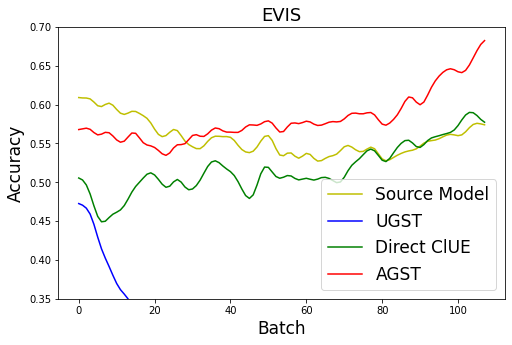

In [21]:
from scipy.ndimage.filters import gaussian_filter1d

figure = plt.figure(figsize=(8,5))

axes = plt.gca()
axes.set_ylim([0.35,0.7])

sigma_ = 1.75

print("Source Acc: ",source_acc[-1])
print("UGST Acc: ",baseline_UGST_acc[-1])
print("Direct Clue Acc: ",direct_clue_acc[-1])
print("AGST(ours) Acc: ",our_acc[-1])

source_acc_ = gaussian_filter1d(source_acc, sigma=sigma_)
baseline_UGST_acc_ = gaussian_filter1d(baseline_UGST_acc, sigma=sigma_)
our_acc_ = gaussian_filter1d(our_acc, sigma=sigma_)
direct_clue_acc_ = gaussian_filter1d(direct_clue_acc, sigma=sigma_)

plt.plot(source_acc_, label="Source Model", color='y')
plt.plot(baseline_UGST_acc_, label="UGST", color="b")
plt.plot(direct_clue_acc_, label= "Direct ClUE", color = 'g')
plt.plot(our_acc_, label="AGST", color='r')

plt.title("EVIS", fontsize=18) 
plt.xlabel('Batch', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.legend(fontsize=17)
# plt.savefig("_result.pdf")
plt.show()

### Ablation Study

In [22]:
# AGST w/o active query

import random

max_iter = 50
# Initialize  model.
model_student = Model(num_classes = 10).to(device)
model_student.load_state_dict(model.state_dict())
model_teacher = Model(num_classes = 10).to(device)
model_teacher.load_state_dict(model.state_dict())

# Define the optimizers w.r.t models.
opt_student = torch.optim.Adam(model_student.parameters(), lr=learning_rate_)
baseline_random_query_acc = []


for year in range(start_year, end_year + 1):
    for month in range(1,13):
        data_set = EVIS_month(root_dir = "data/EVIS_40", year = year, month = month, transform = transform_test)
        data_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)
        
        x_i, y_i = next(iter(data_loader))
        x_i = x_i.to(device)
        y_i = y_i.to(device)  
       
        psuedo_y_i = F.softmax(model_student(x_i), dim = 1)
        confidence = torch.max(psuedo_y_i, 1)[0] - torch.min(psuedo_y_i, 1)[0]

        indices = (confidence > alpha_threshold).nonzero().flatten().cpu().numpy()
        x_learn = x_i[indices]
        psuedo_label = psuedo_y_i.argmax(dim=1).cpu().numpy()
        y_learn = torch.from_numpy(psuedo_label[indices]).to(device)

        indices = (confidence > alpha_threshold).nonzero().flatten().cpu().numpy()
        _indices = np.argsort(confidence.detach().cpu().numpy())[0:kmeansorder]

        to_clue_data = x_i[_indices].cpu().numpy()

        active_queries = random.sample(range(0, len(data_set)), kmeansorder)

        queried_x = x_i[active_queries]
        queried_label = y_i[active_queries]

        psuedo_label = psuedo_y_i.argmax(dim=1)
        x_learn = x_i[indices]
        y_learn = psuedo_label[indices]

        rate_q = len(queried_x)/(len(queried_x) + len(x_learn))

        print(len(to_clue_data), len(x_learn))

        for epoch in range(epoch_num): 
            # looped training process.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            loss = criterion(output_queried, queried_label) + criterion(outputs, y_learn) + reg_weight*l1_norm(model_student, model_teacher)

            # backward
            opt_student.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student.step() # update parameters by gradient descent.

        model_teacher.load_state_dict(model_student.state_dict())

        y_i_hat = F.softmax(model_student(x_i), dim = 1)
        acc = binary_accuracy(y_i_hat, y_i)
        baseline_random_query_acc.append(acc)


        print(year, month, len(data_set), acc)

40 278
2012 1 418 0.5191387559808612
40 264
2012 2 421 0.47268408551068886
40 262
2012 3 417 0.539568345323741
40 285
2012 4 419 0.568019093078759
40 293
2012 5 416 0.5264423076923077
40 243
2012 6 402 0.5174129353233831
40 258
2012 7 400 0.4675
40 257
2012 8 400 0.54
40 257
2012 9 399 0.5413533834586466
40 255
2012 10 400 0.515
40 249
2012 11 400 0.4975
40 272
2012 12 400 0.5125
40 260
2013 1 399 0.506265664160401
40 258
2013 2 400 0.53
40 247
2013 3 399 0.5538847117794486
40 261
2013 4 400 0.5625
40 265
2013 5 400 0.505
40 263
2013 6 400 0.5475
40 276
2013 7 400 0.5475
40 275
2013 8 400 0.55
40 265
2013 9 400 0.505
40 252
2013 10 400 0.4925
40 267
2013 11 400 0.5675
40 258
2013 12 400 0.4875
40 251
2014 1 400 0.46
40 270
2014 2 400 0.5175
40 274
2014 3 400 0.57
40 263
2014 4 400 0.4875
40 262
2014 5 400 0.475
40 277
2014 6 400 0.5175
40 276
2014 7 400 0.56
40 265
2014 8 400 0.4975
40 270
2014 9 400 0.5275
40 258
2014 10 399 0.48872180451127817
40 288
2014 11 400 0.545
40 269
2014 12 

In [23]:
# AGST w/o regularization

max_iter = 50
# Initialize  model.
model_student = Model(num_classes = 10).to(device)
model_student.load_state_dict(model.state_dict())
model_teacher = Model(num_classes = 10).to(device)
model_teacher.load_state_dict(model.state_dict())

# Define the optimizers w.r.t models.
opt_student_extractor = torch.optim.Adam([{
        'params': model_student.features.parameters()
    }], lr=learning_rate_)
opt_student_classifier = torch.optim.Adam([{
        'params': model_student.base_model.fc.parameters()
    }], lr=learning_rate_)
our_ablation_no_reg_acc = []


for year in range(start_year, end_year + 1):
    for month in range(1,13):
        data_set = EVIS_month(root_dir = "data/EVIS_40", year = year, month = month, transform = transform_test)
        data_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)
        
        x_i, y_i = next(iter(data_loader))
        x_i = x_i.to(device)
        y_i = y_i.to(device)  
       
        psuedo_y_i = F.softmax(model_student(x_i), dim = 1)
        confidence = torch.max(psuedo_y_i, 1)[0] - torch.min(psuedo_y_i, 1)[0]

        indices = (confidence > alpha_threshold).nonzero().flatten().cpu().numpy()
        _indices = (confidence <= beta_threshold).nonzero().flatten().cpu().numpy()
        
        to_clue_data = x_i[_indices]
        to_clue_y = y_i[_indices]
        
        if len(to_clue_data) > kmeansorder:
            active_queries = active_query_clue(to_clue_data.cpu().numpy(), model_student, kmeansorder, max_iter)
            queried_x = to_clue_data[active_queries]
            queried_label = to_clue_y[active_queries]
    
        else:
            active_queries = np.argsort(confidence.detach().cpu().numpy())[0:kmeansorder]
            queried_x = x_i[active_queries]
            queried_label = y_i[active_queries]
    
        
        
        psuedo_label = psuedo_y_i.argmax(dim=1)
        x_learn = x_i[indices]
        y_learn = psuedo_label[indices]

        rate_q = len(queried_x)/(len(queried_x) + len(x_learn))

        print(len(to_clue_data), len(x_learn))

        for epoch in range(epoch_num): 
            # looped training process.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            output_ = model_student(x_i)
            loss = (max(len(to_clue_data), kmeansorder) / 20 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) 
                    + lambda_h * self_entropy(output_) 
                    + 0*l1_norm(model_student, model_teacher))
            
            # backward
            opt_student_extractor.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_extractor.step() # update parameters by gradient descent.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            output_ = model_student(x_i)
            loss = (max(len(to_clue_data), kmeansorder) / 20 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) 
                    - lambda_h * self_entropy(output_) 
                    + 0*l1_norm(model_student, model_teacher))
            
            # backward
            opt_student_classifier.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_classifier.step() # update parameters by gradient descent.


        model_teacher.load_state_dict(model_student.state_dict())

        y_i_hat = F.softmax(model_student(x_i), dim = 1)
        acc = binary_accuracy(y_i_hat, y_i)
        our_ablation_no_reg_acc.append(acc)


        print(year, month, len(data_set), acc)

280 278
2012 1 418 0.5813397129186603
269 285
2012 2 421 0.5558194774346793
266 266
2012 3 417 0.5419664268585132
250 284
2012 4 419 0.6014319809069213
271 278
2012 5 416 0.5841346153846154
270 247
2012 6 402 0.5422885572139303
263 257
2012 7 400 0.54
265 276
2012 8 400 0.565
255 286
2012 9 399 0.5764411027568922
270 263
2012 10 400 0.4875
271 254
2012 11 400 0.485
246 275
2012 12 400 0.5475
273 257
2013 1 399 0.5263157894736842
273 263
2013 2 400 0.53
278 275
2013 3 399 0.5388471177944862
273 270
2013 4 400 0.59
267 271
2013 5 400 0.5375
276 253
2013 6 400 0.5325
269 278
2013 7 400 0.5625
267 261
2013 8 400 0.5675
268 270
2013 9 400 0.535
271 261
2013 10 400 0.51
261 257
2013 11 400 0.6175
271 263
2013 12 400 0.485
276 261
2014 1 400 0.5175
272 259
2014 2 400 0.5475
260 275
2014 3 400 0.6275
277 259
2014 4 400 0.555
282 259
2014 5 400 0.545
290 243
2014 6 400 0.54
244 272
2014 7 400 0.61
279 250
2014 8 400 0.5675
290 247
2014 9 400 0.5775
288 216
2014 10 399 0.5338345864661654
261 264

In [24]:
# AGST w/o pseudolabel

max_iter = 70
# Initialize  model.
model_student = Model(num_classes = 10).to(device)
model_student.load_state_dict(model.state_dict())
model_teacher = Model(num_classes = 10).to(device)
model_teacher.load_state_dict(model.state_dict())

# Define the optimizers w.r.t models.
opt_student_extractor = torch.optim.Adam([{
        'params': model_student.features.parameters()
    }], lr=learning_rate_)
opt_student_classifier = torch.optim.Adam([{
        'params': model_student.base_model.fc.parameters()
    }], lr=learning_rate_)
no_psuedo_acc = []


for year in range(start_year, end_year + 1):
    for month in range(1,13):
        data_set = EVIS_month(root_dir = "data/EVIS_40", year = year, month = month, transform = transform_test)
        data_loader = torch.utils.data.DataLoader(data_set,batch_size=len(data_set), shuffle=True, pin_memory=False, drop_last=True)
        
        x_i, y_i = next(iter(data_loader))
        x_i = x_i.to(device)
        y_i = y_i.to(device)  
       
        psuedo_y_i = F.softmax(model_student(x_i), dim = 1)
        confidence = torch.max(psuedo_y_i, 1)[0] - torch.min(psuedo_y_i, 1)[0]

        indices = (confidence > alpha_threshold).nonzero().flatten().cpu().numpy()
        _indices = (confidence <= beta_threshold).nonzero().flatten().cpu().numpy()
        
        to_clue_data = x_i[_indices]
        to_clue_y = y_i[_indices]
        
        if len(to_clue_data) > kmeansorder:
            active_queries = active_query_clue(to_clue_data.cpu().numpy(), model_student, kmeansorder, max_iter)
            queried_x = to_clue_data[active_queries]
            queried_label = to_clue_y[active_queries]
    
        else:
            active_queries = np.argsort(confidence.detach().cpu().numpy())[0:kmeansorder]
            queried_x = x_i[active_queries]
            queried_label = y_i[active_queries]
    
        
        
        psuedo_label = psuedo_y_i.argmax(dim=1)
        x_learn = x_i[indices]
        y_learn = psuedo_label[indices]

        rate_q = len(queried_x)/(len(queried_x) + len(x_learn))

        print(len(to_clue_data), len(x_learn))

        for epoch in range(epoch_num): 
            # looped training process.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            output_ = model_student(x_i)
            loss = (0 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) 
                    + lambda_h * self_entropy(output_) 
                    + reg_weight*l1_norm(model_student, model_teacher))
            
            # backward
            opt_student_extractor.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_extractor.step() # update parameters by gradient descent.

            # forward
            outputs = model_student(x_learn)
            output_queried = model_student(queried_x)
            output_ = model_student(x_i)
            loss = (0 * criterion(output_queried, queried_label) 
                    + criterion(outputs, y_learn) 
                    - lambda_h * self_entropy(output_) 
                    + reg_weight*l1_norm(model_student, model_teacher))
            
            # backward
            opt_student_classifier.zero_grad() # zero the grads before bp gradient.
            loss.backward()
            opt_student_classifier.step() # update parameters by gradient descent.


        model_teacher.load_state_dict(model_student.state_dict())

        y_i_hat = F.softmax(model_student(x_i), dim = 1)
        acc = binary_accuracy(y_i_hat, y_i)
        no_psuedo_acc.append(acc)


        print(year, month, len(data_set), acc)

280 278
2012 1 418 0.49521531100478466
281 272
2012 2 421 0.4584323040380047
278 268
2012 3 417 0.5251798561151079
275 284
2012 4 419 0.5417661097852029
295 283
2012 5 416 0.5072115384615384
293 248
2012 6 402 0.4701492537313433
280 269
2012 7 400 0.445
289 256
2012 8 400 0.5
264 268
2012 9 399 0.48872180451127817
261 246
2012 10 400 0.4875
264 276
2012 11 400 0.4475
250 280
2012 12 400 0.465
241 279
2013 1 399 0.44360902255639095
251 284
2013 2 400 0.4025
242 295
2013 3 399 0.45363408521303256
206 303
2013 4 400 0.45
228 295
2013 5 400 0.3775
223 311
2013 6 400 0.3975
199 312
2013 7 400 0.4
196 316
2013 8 400 0.38
177 333
2013 9 400 0.34
178 336
2013 10 400 0.325
176 331
2013 11 400 0.315
163 335
2013 12 400 0.3475
161 333
2014 1 400 0.325
153 346
2014 2 400 0.3175
157 349
2014 3 400 0.3475
153 345
2014 4 400 0.29
129 354
2014 5 400 0.305
144 353
2014 6 400 0.325
123 354
2014 7 400 0.3225
129 359
2014 8 400 0.285
131 358
2014 9 400 0.2525
111 358
2014 10 399 0.2581453634085213
120 363

Result

AGST Acc:  0.7
AGST w/o active query Acc:  0.63
AGST w/o regularization Acc:  0.6675
AGST w/o pseudolabel Acc:  0.2075


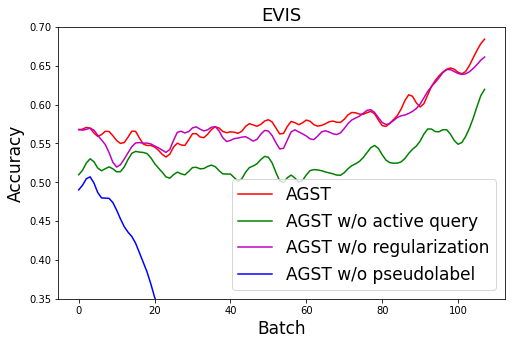

In [25]:
from scipy.ndimage.filters import gaussian_filter1d

figure = plt.figure(figsize=(8,5))

axes = plt.gca()
axes.set_ylim([0.35,0.7])

sigma_ = 1.55

print("AGST Acc: ",our_acc[-1])
print("AGST w/o active query Acc: ",baseline_random_query_acc[-1])
print("AGST w/o regularization Acc: ",our_ablation_no_reg_acc[-1])
print("AGST w/o pseudolabel Acc: ",no_psuedo_acc[-1])


baseline_random_query_acc_ = gaussian_filter1d(baseline_random_query_acc, sigma=sigma_)
our_acc_ = gaussian_filter1d(our_acc, sigma=sigma_)
our_ablation_no_reg_acc_ = gaussian_filter1d(our_ablation_no_reg_acc, sigma=sigma_)
no_psuedo_acc_ = gaussian_filter1d(no_psuedo_acc, sigma=sigma_)


plt.plot(our_acc_, label="AGST", color='r')
plt.plot(baseline_random_query_acc_, label="AGST w/o active query", color='g')
plt.plot(our_ablation_no_reg_acc_, label="AGST w/o regularization", color='m')
plt.plot(no_psuedo_acc_, label="AGST w/o pseudolabel", color='b')

# plt.yscale('symlog')
plt.title("EVIS", fontsize=18) 
plt.xlabel('Batch', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.legend(fontsize=17)
# plt.savefig("TMM_Web_result_ablation.pdf")
plt.show()